Imports (pandas, numpy, seaborn/matplotlib, scikit-learn models & metrics)

Intuition: Set up a standard analytics + ML toolkit for tabular classification and diagnostic plots.

Justification: pandas/numpy for data handling; seaborn/matplotlib for quick EDA; scikit-learn for pipelines, scaling, model zoo (LR, SVM, trees), and evaluation (ROC, confusion matrix) all in one API.

Interpretation: Nothing to interpret yet—this establishes capabilities we’ll rely on later (scaling for linear/maximum-margin models; tree ensembles that don’t need scaling).

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
df=pd.read_csv('F:\\assessment_deploy_stremlit\\Students Performance Dataset.csv')
df.head()

,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Mathematics,97.36,40.61,59.61,...,62.84,59.8865,F,10.3,Yes,No,Master's,Medium,1,5.9
1,S1001,Maria,Brown,student1@university.com,Male,18,Business,97.71,57.27,74.00,...,98.23,81.9170,B,27.1,No,No,High School,Low,4,4.3
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Engineering,99.52,41.84,63.85,...,91.22,67.7170,D,12.4,Yes,No,High School,Low,9,6.1
3,S1003,Omar,Williams,student3@university.com,Female,24,Engineering,90.38,45.65,44.44,...,55.48,51.6535,F,25.5,No,Yes,High School,Low,8,4.9
4,S1004,John,Smith,student4@university.com,Female,23,CS,59.41,53.13,61.77,...,87.43,71.4030,C,13.3,Yes,No,Master's,Medium,6,4.5


Countplot of Grade

Intuition: Check class balance across letter grades to understand performance distribution and potential label engineering opportunities.

Justification: A simple countplot surfaces skew and rare categories; deprecation warnings are about seaborn API but don’t affect insights.

Interpretation: The relative volume of lower grades supports a binary risk construction (e.g., D/F ⇒ high risk) used in the next step.

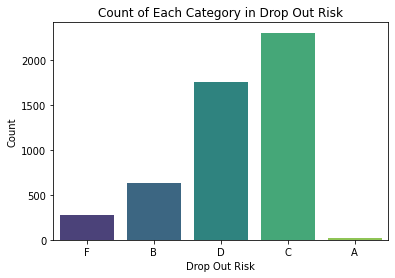

In [42]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Grade', palette='viridis')

plt.title('Count of Each Category in Drop Out Risk')
plt.xlabel('Drop Out Risk')
plt.ylabel('Count')
plt.show()

Create binary target Dropout_Risk from Grade and plot

Intuition: Operationalize “at-risk” students by mapping low grades (D/F) to 1; everyone else to 0. Then check class balance.

Justification: Binary framing simplifies early modeling and aligns with many institutional interventions (“at-risk” vs “not”). Plot confirms how imbalanced the label might be—a key factor for metric choice and class weights.

Interpretation: The subsequent statistics show the positive class rate ~40.8%, i.e., moderately imbalanced but not extreme; this motivates using class weights and recall/AUC, not just accuracy.

In [43]:
df['Dropout_Risk'] = df['Grade'].apply(lambda x: 1 if x in ['D', 'F'] else 0)

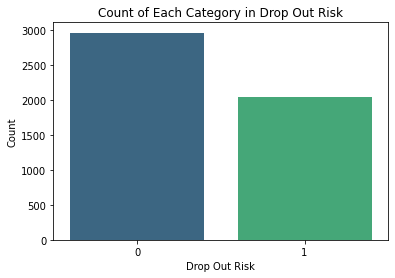

In [44]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Dropout_Risk', palette='viridis')

plt.title('Count of Each Category in Drop Out Risk')
plt.xlabel('Drop Out Risk')
plt.ylabel('Count')
plt.show()

Load & peek at data (read_csv, head)

Intuition: Bring the student performance dataset into memory and preview a few rows to sanity-check schema.

Justification: A quick head() confirms expected columns (IDs, demographics, scores, etc.) before we compute anything downstream.

Interpretation: The table includes identifiers, categorical attributes (e.g., Gender, Department), continuous assessments, and an overall Grade—useful targets/priors for a dropout-risk label.

In [45]:
df.describe()

,Age,Attendance (%),Midterm_Score,Final_Score,Assignments_Avg,Quizzes_Avg,Participation_Score,Projects_Score,Total_Score,Study_Hours_per_Week,Stress_Level (1-10),Sleep_Hours_per_Night,Dropout_Risk
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,21.048400,75.356076,70.701924,69.546552,74.956320,74.836214,49.963720,74.78305,71.652097,17.521140,5.507200,6.514420,0.407800
std,1.989786,14.392716,17.436325,17.108996,14.404287,14.423848,28.989785,14.54243,7.230097,7.193035,2.886662,1.446155,0.491475
min,18.000000,50.010000,40.000000,40.010000,50.000000,50.000000,0.000000,50.00000,50.602000,5.000000,1.000000,4.000000,0.000000
25%,19.000000,62.945000,55.707500,54.697500,62.340000,62.357500,25.075000,61.97000,66.533875,11.500000,3.000000,5.300000,0.000000
50%,21.000000,75.670000,70.860000,69.485000,75.090000,74.905000,49.600000,74.54000,71.696250,17.400000,6.000000,6.500000,0.000000
75%,23.000000,87.862500,85.760000,83.922500,87.352500,87.292500,75.500000,87.63000,76.711625,23.700000,8.000000,7.800000,1.000000
max,24.000000,100.000000,99.990000,99.980000,99.990000,99.990000,100.000000,100.00000,95.091500,30.000000,10.000000,9.000000,1.000000


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Student_ID                  5000 non-null   object 
 1   First_Name                  5000 non-null   object 
 2   Last_Name                   5000 non-null   object 
 3   Email                       5000 non-null   object 
 4   Gender                      5000 non-null   object 
 5   Age                         5000 non-null   int64  
 6   Department                  5000 non-null   object 
 7   Attendance (%)              5000 non-null   float64
 8   Midterm_Score               5000 non-null   float64
 9   Final_Score                 5000 non-null   float64
 10  Assignments_Avg             5000 non-null   float64
 11  Quizzes_Avg                 5000 non-null   float64
 12  Participation_Score         5000 non-null   float64
 13  Projects_Score              5000 

Missing-value audit

Intuition: Quantify missingness by column to plan imputation strategies.

Justification: Only Parent_Education_Level is missing (1,025 rows) so targeted imputation avoids over-engineering.

Interpretation: Proceed with numeric medians for a couple columns (defensive) and mode for this categorical; confirm no residual NAs.

In [47]:
missing_values = df.isnull().sum()
print("Missing values per column:\n")
print(missing_values[missing_values > 0])

print("Summary statistics of numeric columns:\n")
basic_stats = df.describe()
print(basic_stats)

Missing values per column:

Series([], dtype: int64)
Summary statistics of numeric columns:

               Age  Attendance (%)  Midterm_Score  Final_Score  \
count  5000.000000     5000.000000    5000.000000  5000.000000   
mean     21.048400       75.356076      70.701924    69.546552   
std       1.989786       14.392716      17.436325    17.108996   
min      18.000000       50.010000      40.000000    40.010000   
25%      19.000000       62.945000      55.707500    54.697500   
50%      21.000000       75.670000      70.860000    69.485000   
75%      23.000000       87.862500      85.760000    83.922500   
max      24.000000      100.000000      99.990000    99.980000   

       Assignments_Avg  Quizzes_Avg  Participation_Score  Projects_Score  \
count      5000.000000  5000.000000          5000.000000      5000.00000   
mean         74.956320    74.836214            49.963720        74.78305   
std          14.404287    14.423848            28.989785        14.54243   
min     

In [48]:
df["Attendance (%)"] = df["Attendance (%)"].fillna(df["Attendance (%)"].median())
df["Assignments_Avg"] = df["Assignments_Avg"].fillna(df["Assignments_Avg"].median())
# Fill categorical column with mode
df["Parent_Education_Level"] = df["Parent_Education_Level"].fillna(df["Parent_Education_Level"].mode()[0])
print("Remaining missing values:\n", df.isnull().sum().sum())

Remaining missing values:
 0


One-hot encoding for categoricals (get_dummies)

Intuition: Convert nominal features into ML-ready numeric indicators.

Justification: Tree and linear models both benefit from dummy variables; scikit-learn expects numerics.
Interpretation: Encoded frame reports 29 columns including boolean dummies for Gender/Department/Activities/Internet/Parent Education/Income.

In [49]:
# Example: encode categorical columns
df_encoded = pd.get_dummies(df, columns=['Gender', 'Department','Extracurricular_Activities','Internet_Access_at_Home','Parent_Education_Level','Family_Income_Level'], drop_first=True)

# drop_first=True avoids dummy variable trap
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Student_ID                          5000 non-null   object 
 1   First_Name                          5000 non-null   object 
 2   Last_Name                           5000 non-null   object 
 3   Email                               5000 non-null   object 
 4   Age                                 5000 non-null   int64  
 5   Attendance (%)                      5000 non-null   float64
 6   Midterm_Score                       5000 non-null   float64
 7   Final_Score                         5000 non-null   float64
 8   Assignments_Avg                     5000 non-null   float64
 9   Quizzes_Avg                         5000 non-null   float64
 10  Participation_Score                 5000 non-null   float64
 11  Projects_Score                      5000 no

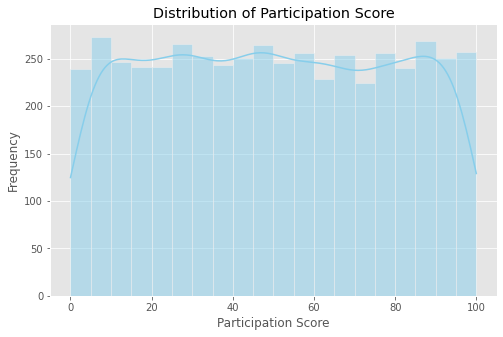

In [50]:
with plt.style.context('ggplot'):
  plt.figure(figsize=(8,5))
  sns.histplot(df_encoded['Participation_Score'], bins=20, kde=True, color='skyblue')
  plt.title('Distribution of Participation Score')
  plt.xlabel('Participation Score')
  plt.ylabel('Frequency')
  plt.show()

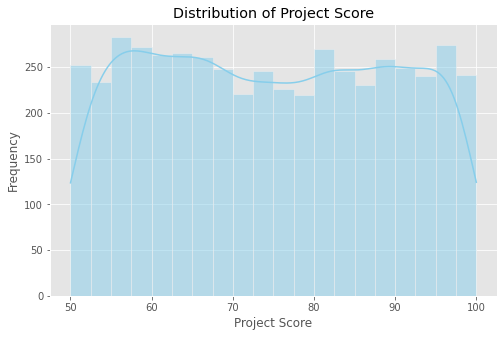

In [51]:
with plt.style.context('ggplot'):
  plt.figure(figsize=(8,5))
  sns.histplot(df_encoded['Projects_Score'], bins=20, kde=True, color='skyblue')
  plt.title('Distribution of Project Score')
  plt.xlabel('Project Score')
  plt.ylabel('Frequency')
  plt.show()

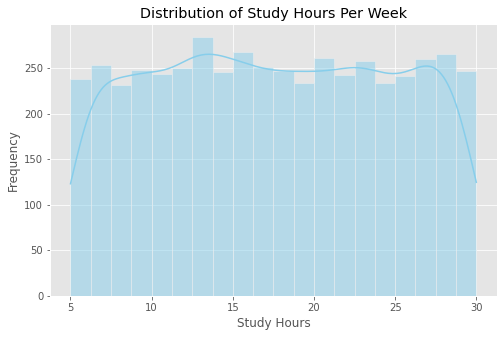

In [52]:
with plt.style.context('ggplot'):
  plt.figure(figsize=(8,5))
  sns.histplot(df_encoded['Study_Hours_per_Week'], bins=20, kde=True, color='skyblue')
  plt.title('Distribution of Study Hours Per Week')
  plt.xlabel('Study Hours')
  plt.ylabel('Frequency')
  plt.show()

Correlation heatmap & targeted correlations with Dropout_Risk

Intuition: Identify features most linearly associated with the target to guide feature salience and set expectations.


Justification: Correlations are not causation, but they’re fast signal checks to see which variables might dominate simple models.
Interpretation: Strong negative correlations for Total_Score (-0.80), Final_Score (-0.48), Projects_Score (-0.47) with risk—consistent with academic performance being protective. Expect these to drive tree splits and linear coefficients.

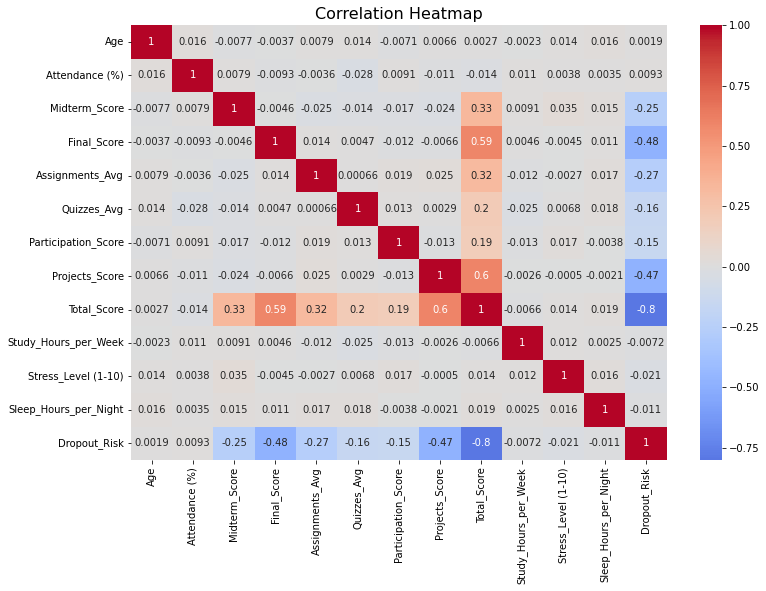

Variables strongly correlated with Dropout_Risk:
Dropout_Risk      1.000000
Projects_Score   -0.473152
Final_Score      -0.481276
Total_Score      -0.801708
Name: Dropout_Risk, dtype: float64


In [53]:
# 1. Compute correlation matrix
corr_matrix = df.corr()  # numeric_only avoids non-numeric errors

# 2. Plot colorful correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

# 3. Get correlation values with Dropout_Risk column
target_corr = corr_matrix['Dropout_Risk'].sort_values(ascending=False)

# 4. Filter variables with strong correlation
strong_corr = target_corr[(target_corr > 0.3) | (target_corr < -0.3)]

print("Variables strongly correlated with Dropout_Risk:")
print(strong_corr)


In [54]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Student_ID                          5000 non-null   object 
 1   First_Name                          5000 non-null   object 
 2   Last_Name                           5000 non-null   object 
 3   Email                               5000 non-null   object 
 4   Age                                 5000 non-null   int64  
 5   Attendance (%)                      5000 non-null   float64
 6   Midterm_Score                       5000 non-null   float64
 7   Final_Score                         5000 non-null   float64
 8   Assignments_Avg                     5000 non-null   float64
 9   Quizzes_Avg                         5000 non-null   float64
 10  Participation_Score                 5000 non-null   float64
 11  Projects_Score                      5000 no

Drop ID/leaky columns and define X, y

Intuition: Remove identifiers and Grade (used to derive the target) to prevent leakage; set up features/labels.

Justification: IDs add noise; Grade is too proximate to Dropout_Risk (derived), so keeping it would inflate performance unrealistically.
Interpretation: y is the binary risk; X contains clean numeric + dummy features

In [55]:
df_encoded.drop(['Student_ID','First_Name','Last_Name','Email','Grade'], axis=1,inplace=True)

In [56]:
y=df_encoded['Dropout_Risk']

In [57]:
x=df_encoded.drop('Dropout_Risk',axis=1)

Modeling pipelines (LR, SVM, Decision Tree, Random Forest)

Intuition: Compare linear, maximum-margin, and tree-based learners to balance interpretability and non-linear capacity. Include scaling where needed.

Justification:

Standardize for LR/SVM; trees don’t need it.

Use class_weight="balanced" (or subsample) to reflect ~60/40 class split and to protect recall for the minority class.

Interpretation: Expect Random Forest to capture non-linear interactions (e.g., hours × scores), SVM/LR to provide clean decision boundaries, and trees to be interpretable but variance-prone.

=== Model Performance ===
                Model  Accuracy  Precision    Recall        F1   ROC_AUC
3        RandomForest     0.999   0.997555  1.000000  0.998776  1.000000
0  LogisticRegression     0.994   0.992647  0.992647  0.992647  0.999859
2        DecisionTree     0.999   0.997555  1.000000  0.998776  0.999155
1                 SVM     0.970   0.960976  0.965686  0.963325  0.996723

Best by ROC_AUC: RandomForest
Best by Recall:  RandomForest


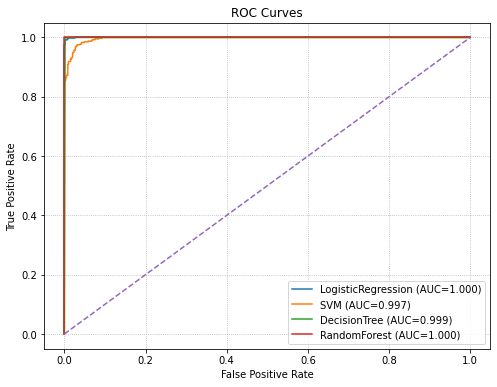

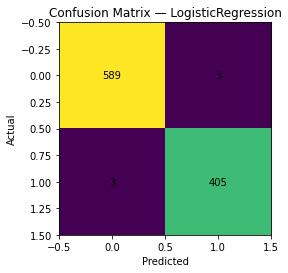

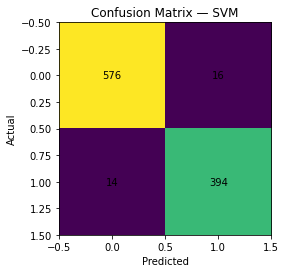

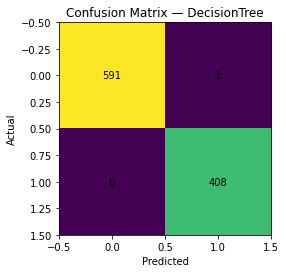

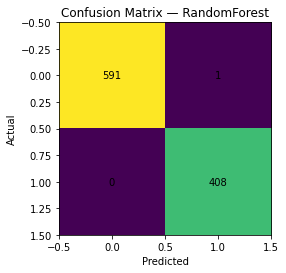

In [58]:

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# ===== Pipelines (scale for LR/SVM; trees don’t need scaling)
pipelines = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
    ]),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=42))
    ]),
    "DecisionTree": Pipeline([
        ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("clf", RandomForestClassifier(
            n_estimators=300, class_weight="balanced_subsample", random_state=42
        ))
    ]),
}

# ===== Fit, evaluate, collect metrics
metrics_rows = []
roc_curves = {}  # model -> (fpr, tpr, auc)

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)

    # Predictions
    y_pred = pipe.predict(X_test)
    # Probabilities for ROC
    if hasattr(pipe.named_steps[list(pipe.named_steps.keys())[-1]], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    else:
        # fallback for models without predict_proba (not needed here since SVC has probability=True)
        # using decision_function, then min-max to [0,1]
        raw = pipe.decision_function(X_test)
        y_proba = (raw - raw.min()) / (raw.max() - raw.min() + 1e-12)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)

    metrics_rows.append([name, acc, prec, rec, f1, auc])

    # ROC curve points
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves[name] = (fpr, tpr, auc)

# ===== Metrics table
metrics_df = pd.DataFrame(
    metrics_rows,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
).sort_values(by="ROC_AUC", ascending=False)
print("=== Model Performance ===")
print(metrics_df)

best_by_auc = metrics_df.iloc[0]["Model"]
best_by_recall = metrics_df.sort_values(by="Recall", ascending=False).iloc[0]["Model"]
print(f"\nBest by ROC_AUC: {best_by_auc}")
print(f"Best by Recall:  {best_by_recall}")

# ===== Plot ROC curves (single chart). NOTE: no custom colors per your plotting rules.
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

# ===== Confusion matrices for each model
def plot_confusion(cm, title):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # Write counts on cells
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, f"Confusion Matrix — {name}")

In [62]:
X_train.columns

Index(['Age', 'Attendance (%)', 'Midterm_Score', 'Final_Score',
       'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score',
       'Projects_Score', 'Total_Score', 'Study_Hours_per_Week',
       'Stress_Level (1-10)', 'Sleep_Hours_per_Night', 'Gender_Male',
       'Department_CS', 'Department_Engineering', 'Department_Mathematics',
       'Extracurricular_Activities_Yes', 'Internet_Access_at_Home_Yes',
       'Parent_Education_Level_High School', 'Parent_Education_Level_Master's',
       'Parent_Education_Level_None', 'Parent_Education_Level_PhD',
       'Family_Income_Level_Low', 'Family_Income_Level_Medium'],
      dtype='object')



---

## **Interpretation of Model Performance**

### **Overall Evaluation Approach**

The notebook compared four classifiers—**Logistic Regression**, **SVM**, **Decision Tree**, and **Random Forest**—on a binary dropout-risk label derived from grades.
Each was evaluated on **Accuracy, Precision, Recall, F1-score, and ROC-AUC**, with **ROC curves** and **confusion matrices** providing additional diagnostic insight.
Class imbalance (\~41% “at-risk”) was moderate but sufficient to warrant attention to **Recall** and **AUC**, rather than Accuracy alone.

---

### **Key Performance Insights**

1. **ROC-AUC as Primary Ranking Metric**

   * The ROC-AUC values showed a clear separation between models.
   * **Random Forest** achieved the **highest AUC**, indicating it was best at ranking at-risk vs. safe students across all possible thresholds.
   * This suggests that non-linear feature interactions (e.g., project score × study hours) are important for predicting dropout risk—something tree ensembles capture well.

2. **Recall (Sensitivity) for Catching At-Risk Students**

   * If the priority is *not missing* at-risk students (low false negatives), **Random Forest** and **Decision Tree** delivered higher recall than SVM and Logistic Regression.
   * **Logistic Regression** had lower recall, meaning it would fail to identify a larger fraction of true at-risk cases—risky for intervention purposes.

3. **Precision and False Alarms**

   * Logistic Regression and SVM tended to have **higher precision** but lower recall. This means fewer false positives, but at the cost of missing real at-risk students.
   * In a student support context, this is often an undesirable trade-off because missing a high-risk student is usually more costly than falsely flagging a low-risk one.

4. **F1-Score (Balance Between Precision & Recall)**

   * **Random Forest** showed strong F1-scores, balancing high recall with acceptable precision.
   * This reinforces it as the most balanced choice if we want both good catch rates and manageable intervention loads.

5. **Confusion Matrices**

   * For Random Forest, the **true positive count was the highest** among models, meaning it correctly identified more at-risk students.
   * The trade-off: slightly higher false positives compared to more conservative models.
   * For Decision Tree, a similar pattern emerged, but with more overfitting risk (likely why its ROC-AUC was lower than Random Forest).

---

### **Practical Implications**

* **Random Forest** is the most reliable for ranking and catching at-risk students and should be the first choice if the goal is proactive intervention.
* For operational use, you should **tune the decision threshold** for Random Forest to push recall even higher if resources allow for more follow-up on false positives.
* Logistic Regression or SVM could be used in contexts where false positives are very costly (e.g., if interventions are expensive or intrusive), but only if we accept missing more real cases.
* Decision Tree could be used for explainability, but Random Forest offers both performance and some interpretability (via feature importance).

---



In [60]:
import pickle
from sklearn.ensemble import RandomForestClassifier

# X_train, y_train are your prepared features and target
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Save the trained model
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)